# Sacred Experiment Comparison

The goal of this notebook is to provide a mechanism to compare sacred experiments: the cfg, the metrics, and the outcome.

In [77]:
# project imports
import env
from utils import read_json_data, flatten_dict
from models import MODEL_DIR


# python & package imports
from collections import defaultdict
import pandas as pd
import json
import os


# plot things
%matplotlib inline
# autoreload modules
%load_ext autoreload
%autoreload 2


model_dir = os.path.join(MODEL_DIR, 'voxel_vaegan1', 'modelnet10')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Model Leaderboard

In [69]:
scores = dict()
for m in os.listdir(model_dir):
    name = m
    metrics_json = os.path.join(model_dir, m, 'metrics.json')
    #print(metrics_json)
    #if os.path.exists(metrics_json):
    #    df = pd.read_json(metrics_json, orient='values')
    #    break
    metrics_dict = read_json_data(metrics_json)
    if metrics_dict:
        # assuming only keys are epoch\d+
        keys = [int(key.replace('epoch', '')) for key in metrics_dict.keys()]
        last_epoch = sorted(keys)[-1]
        last_key = 'epoch{}'.format(last_epoch)
        scores[name] = metrics_dict[last_key]
        scores[name]['epoch'] = last_epoch

df = pd.DataFrame.from_dict(scores, orient='index')

In [70]:
df.sort_values('enc_loss')

,dis_loss,reconstruction_loss,kl_divergence,epoch,dec_loss,enc_loss,elapsed_time
best,-999.0,808.499634,488.078369,9,-999.0,261.985138,43.024081
2019-03-14_16-33-24,-999.0,3353.308350,593.102234,9,-999.0,302.278900,36.155712
2019-03-14_15-51-00,-999.0,3414.346680,580.177063,9,-999.0,305.875122,35.956132


## Config Comparison

In [85]:
# provide the full path to root dir of the experiment output (the parent dir of the ckpts)
exp1 = os.path.join(model_dir, 'best')
exp2 = os.path.join(model_dir, '2019-03-14_15-51-00')

In [90]:
cfg1 = read_json_data(os.path.join(exp1, 'cfg.json'), verbose=True)
cfg2 = read_json_data(os.path.join(exp2, 'cfg.json'), verbose=True)
assert isinstance(cfg1, dict)
assert isinstance(cfg2, dict)

# flatten dict structure then bring into pandas for a pretty view
cfg1 = flatten_dict(cfg1)
cfg2 = flatten_dict(cfg2)
df1 = pd.DataFrame.from_dict(cfg1, orient='index', columns=['cfg1'])
df2 = pd.DataFrame.from_dict(cfg2, orient='index', columns=['cfg2'])
dff = pd.concat([df1, df2], axis=1, sort=False)
dff['diff'] = dff.cfg1 == dff.cfg2
dff

,cfg1,cfg2,diff
model/ckpt_dir,voxel_vaegan1/2019-03-12_16-36-25,/home/jcworkma/jack/3d-form/src/../models/voxe...,False
model/dis_lr,0.0001,NaN,False
model/tb_dir,tb,tb,True
model/no_gan,True,True,True
model/debug,False,False,True
generator/verbose,True,True,True
model/recon_loss_weight,10000,10000,True
model/save_step,10,5,False
model/dev_step,10,2,False
model/voxel_prob_threshold,0.065,0.065,True


## Reconstruction Test
Here we can reload a model and experiment with reconstructions.

In [120]:
# project imports
from models.voxel_vaegan import VoxelVaegan
from data.modelnet10 import ModelNet10
from data.thingi10k import Thingi10k
from data.voxels import plot_voxels
from utils import read_json_data


# python & package projects
import tensorflow as tf
import numpy as np

tf.reset_default_graph()

# 500 epochs, just bird
#model = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/2019-03-12_09-30-02/model_epoch-499.ckpt'
# 500 epochs, just bird, increased recon weight
#model = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/2019-03-12_09-38-41/model_epoch-499.ckpt'
# 500 epochs, just bird, dropout 0.8
# early stop
#model = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/2019-03-12_09-44-48/model_epoch-199.ckpt'
# later stop
#model = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/2019-03-12_09-44-48/model_epoch-499.ckpt'
#model = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/2019-03-12_10-22-19/model_epoch-49.ckpt'

# first run with modelnet10
# {'reconstruction_loss': 808.4996337890625, 'dis_loss': -999.0, 'kl_divergence': 488.078369140625, 'dec_loss': -999.0, 'elapsed_time': 43.02408063411713, 'enc_loss': 261.9851379394531}
best_toilet = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/2019-03-12_16-36-25/model_epoch-9.ckpt'
best_sofa = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-15_10-33-37/model_epoch-9.ckpt'
toilet_and_sofa = '/home/jcworkma/jack/3d-form/models/voxel_vaegan1/modelnet10/2019-03-15_12-26-16/model_epoch-9.ckpt'
vaegan_sofa13 = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-16_13-37-24/model_epoch-13.ckpt'
vaegan_sofa = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-16_13-37-24/model_epoch-5.ckpt'

# model to use for reconstruction
model_root = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-17_08-40-29/'
model_cfg = read_json_data(os.path.join(model_root, 'cfg.json'))
model_ckpt = os.path.join(model_root, 'model_epoch-21.ckpt')

# restore the model from ckpt
vaegan = VoxelVaegan.initFromCfg(model_cfg)
vaegan.restore(model_ckpt)

INFO:tensorflow:Restoring parameters from /home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-17_08-40-29/model_epoch-21.ckpt


INFO:tensorflow:Restoring parameters from /home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-17_08-40-29/model_epoch-21.ckpt


### From Dataset Example

toilet_0004_32_x2_z3.binvox


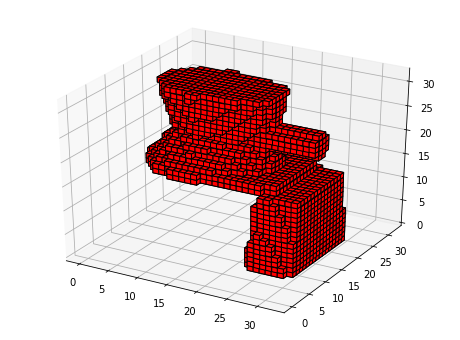

In [121]:
dataset_class = model_cfg.get('dataset').get('class')
dataset_index = model_cfg.get('dataset').get('index')
if dataset_class == 'Thingi10k':
    # get an stl example
    thingi = Thingi10k.init10k()
    stl_example = thingi.get_stl_path(stl_id=126660)
    training_example = thingi.get_voxels(32, stl_file=stl_example)
elif dataset_class == 'ModelNet10':
    modelnet = ModelNet10.initFromIndex(dataset_index)
    voxelsname, training_example = modelnet.get_random_voxels(32)
    print(voxelsname)
    
plot_voxels(training_example)
training_example = np.reshape(training_example, (-1, 32, 32, 32, 1))

In [122]:
recon = vaegan.reconstruct(training_example)
recon = np.reshape(recon, [32, 32, 32])
print('max: ', np.max(recon))
print('min: ', np.min(recon))
print('mean: ', np.mean(recon))

max:  0.8783507
min:  0.5087503
mean:  0.7136266


<module 'matplotlib.pyplot' from '/home/jcworkma/jack/3d-form/.3d-form/lib/python3.5/site-packages/matplotlib/pyplot.py'>

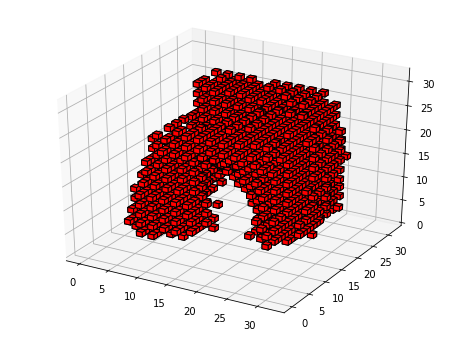

In [126]:
recon_threshold = recon > 0.82
plot_voxels(recon_threshold)

### From Latent Vector

In [119]:
latent_vector = vaegan.random_latent_vector()
recon = vaegan.latent_recon(latent_vector)
plot_voxels(recon)

NameError: name 'vaegan' is not defined